In [1]:
gpus = [2]
import os
os.environ['CUDA_VISIBLE_DEVICES']=','.join([str(i) for i in gpus])

In [2]:
import tensorflow as tf
# tf.enable_eager_execution()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from glob import glob
import pickle
from tensorflow.keras import layers, Sequential, datasets, models, losses, Model, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import datetime
import sys
from tensorflow.keras.backend import clear_session
from trainingfuncs import *
from math_utils import *

In [3]:
tf.compat.v1.disable_eager_execution()

# Load data

In [4]:
sys.path.append("..") # Adds higher directory to python modules path.
from helpers.dataset_vars import *
from helpers.myclasses import *

In [5]:
dataset = Dataset('Starling')
analysis = 'stable_length'

In [6]:
results_folder = os.path.abspath('/mnt/cube/kai/results/sound_texture/classifier')
species_folder = dataset.path_save
analysis_folder = os.path.join(species_folder, analysis)
log_folder = os.path.join(analysis_folder, 'log')

In [7]:
spec_file = sorted(glob(os.path.join(log_folder, 'all_specs_star.p')))[-1]

In [8]:
spec_df = pickle.load(open(spec_file, 'rb'))

In [9]:
spec_df.tail()

,name,wav,spec
6995,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.8473503, -0.74000514, -0.6745358, -0.6307..."
6996,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.618756, -0.6190624, -0.6269182, -0.641789..."
6997,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.39242423, -0.3716945, -0.35015196, -0.346..."
6998,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.71081, -0.7151853, -0.5816425, -0.5211242..."
6999,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.63244075, -0.59842235, -0.56845856, -0.55..."


In [10]:
subjs = sorted(spec_df.name.value_counts().keys().tolist())

In [11]:
spec_h, spec_w = spec_df.spec[0].shape
print(spec_h, spec_w)

291 707


In [12]:
spec_list = spec_df.spec.values.tolist()

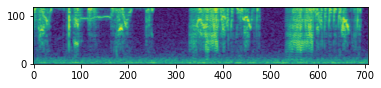

In [13]:
plt.imshow(spec_list[0][:120,:], origin='lower')

In [14]:
subj_list = spec_df.name.values.tolist()

In [15]:
n_slices = (4, 1)

# This notebook is on only horizontal slices (spectral slices)

## Define model

In [16]:
clear_session()

## parse inputs and outputs

In [17]:
divided_w = spec_w//3

In [55]:
spec_h

291

In [19]:
input_list = []
output_list = []

for spec in spec_list:
    for i in range(3):
        slice_list, index_list = slice_matrix(spec[:, divided_w*i:divided_w*(i+1)], 
                                              n_slices=n_slices, slice_shape=(55, 224))
        input_list.append(slice_list)
        output_list.append(index_list)

In [20]:
input_data = np.array(input_list)

In [21]:
input_data = np.transpose(input_data, (1, 0, 2, 3, 4))

In [22]:
input_data = list(input_data)

In [23]:
output_data = np.array(output_list)

In [24]:
output_data.shape

(21000, 4)

In [25]:
input_train, input_test, output_train, output_test = train_test_split(input_list, output_list, test_size = 0.1, 
                                                                      random_state=20)

In [26]:
n_train, _, h, w, _ = np.array(input_train).shape

In [27]:
print(n_train, h, w)

18900 55 224


In [28]:
model=self_VGG()

## connect dense layers and input/output

In [29]:
model_inputs = []
for i in range(np.product(n_slices)):
    model_inputs.append(Input(shape=(h, w, 3)))

In [30]:
encodings = []
for i in range(np.product(n_slices)):
    resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs[i])
    encodings.append(model(resized))
concated = layers.Concatenate(axis=1)(encodings)
dense = layers.Dense(4096)(concated)
model_output = layers.Dense(np.product(n_slices))(dense) # this needs to be changed for both temporal and spectral slices
cfn = Model(model_inputs, model_output)

In [31]:
cfn.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 55, 224, 3)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 55, 224, 3)] 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 55, 224, 3)] 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 55, 224, 3)] 0                                            
_______________________________________________________________________________________

In [33]:
cfn.compile(loss='mse', optimizer = Adam(0.000001)) # need to figure out how to implement FY loss

## train the model to sort spectral slices order

In [34]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')
run_folder = extend_folder(results_folder, '{:%Y_%m_%d_%H_%M_%S}'.format(datetime.datetime.now()))
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model trained on spectral slicing of Starling songs in star scale, 4 slices')

In [35]:
patience = 20
batch_size = 32
epochs = 1000

In [ ]:
model_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_loss', patience=patience, verbose=1),
            ModelCheckpoint(filepath=model_file, monitor='val_loss', save_best_only=True, verbose=0)]

cfn.fit(x = input_data, y = output_data, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_split=0.1)

Train on 18900 samples, validate on 2100 samples
Epoch 1/1000
18900/18900 [==============================] - ETA: 0s - loss: 1.6971WARNING:tensorflow:From /home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
18900/18900 [==============================] - 563s 30ms/sample - loss: 1.6971 - val_loss: 1.2604
Epoch 2/1000
18900/18900 [==============================] - 558s 30ms/sample - loss: 1.2311 - val_loss: 1.2263
Epoch 3/1000
18900/18900 [==============================] - 564s 30ms/sample - loss: 0.7289 - val_loss: 0.2562
Epoch 4/1000
18900/18900 [==============================] - 648s 34ms/sample - loss: 0.1110 - val_loss: 0.0797
Epoch 5/1000
18900/18900 [==============================]

Epoch 70/1000
18900/18900 [==============================] - 559s 30ms/sample - loss: 0.0194 - val_loss: 0.0176
Epoch 71/1000
18900/18900 [==============================] - 557s 29ms/sample - loss: 0.0203 - val_loss: 0.0180
Epoch 72/1000
18900/18900 [==============================] - 556s 29ms/sample - loss: 0.0194 - val_loss: 0.0217
Epoch 73/1000
18900/18900 [==============================] - 556s 29ms/sample - loss: 0.0192 - val_loss: 0.0189
Epoch 74/1000
18900/18900 [==============================] - 557s 29ms/sample - loss: 0.0187 - val_loss: 0.0181
Epoch 75/1000
18900/18900 [==============================] - 557s 29ms/sample - loss: 0.0192 - val_loss: 0.0178
Epoch 76/1000
18900/18900 [==============================] - 564s 30ms/sample - loss: 0.0192 - val_loss: 0.0175
Epoch 77/1000
18900/18900 [==============================] - 560s 30ms/sample - loss: 0.0192 - val_loss: 0.0216
Epoch 78/1000
18900/18900 [==============================] - 557s 29ms/sample - loss: 0.0184 - val_loss:

In [ ]:
pickle.dump([input_data, output_data], open(os.path.join(run_folder, 'train_data.p'), 'wb'))

In [38]:
cfn.load_weights(model_file)

In [39]:
input_test = np.array(input_test)

In [40]:
print(input_test.shape)

(2100, 4, 55, 224, 3)


In [41]:
input_test = list(input_test.transpose((1,0,2,3,4)))

In [42]:
prediction_test = cfn.predict(input_test)

In [43]:
prediction_test[0]

array([2.9103746 , 0.08705732, 1.0124377 , 1.980084  ], dtype=float32)

## prediction error (rmse)

In [44]:
print(np.sqrt(np.mean(np.square(prediction_test-output_test))))

0.07441241390426787


In [189]:
del cfn

In [45]:
prediction_test_int = np.round(prediction_test)

In [46]:
print(prediction_test_int[1])

[2. 0. 3. 1.]


In [47]:
print(np.mean(prediction_test_int==output_test))

1.0


# fine tune on subject classification

## first preserve slicing scheme, concatenate all features

### make inputs and outputs

In [16]:
spec_df.tail()

,name,wav,spec
6995,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.8473503, -0.74000514, -0.6745358, -0.6307..."
6996,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.618756, -0.6190624, -0.6269182, -0.641789..."
6997,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.39242423, -0.3716945, -0.35015196, -0.346..."
6998,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.71081, -0.7151853, -0.5816425, -0.5211242..."
6999,b1160,/mnt/cube/kai/data_processed/datasets/Starling...,"[[-0.63244075, -0.59842235, -0.56845856, -0.55..."


In [17]:
subj_list = spec_df.name.values.tolist()

In [18]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
output_data = enc.fit_transform(np.array(subj_list).reshape((len(subj_list), 1))).toarray()

In [19]:
import itertools
output_data = np.array(list(itertools.chain.from_iterable(itertools.repeat(x, 3) for x in output_data)))

In [22]:
np.unique(output_data, return_counts=True, axis=0)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500,


In [21]:
input_list = []
output_list = []

for spec in spec_list:
    spec_h, spec_w = spec.shape
    divided_w = spec_w//3
    for i in range(3):
        slice_list, index_list = slice_matrix(spec[:, divided_w*i:divided_w*(i+1)], 
                                              n_slices=n_slices, 
                                              slice_shape=(spec_h//n_slices[0], divided_w//n_slices[1]), 
                                              permute=False)
        input_list.append(slice_list)

In [23]:
n_samples, n_outputs=output_data.shape
h, w = input_list[0][0].shape[:2]
print(n_samples, n_outputs, h, w)

21000 14 72 235


In [26]:
input_train, input_test, output_train, output_test = train_test_split(input_list, output_data, test_size = 0.2, 
                                                                      random_state=20, stratify=output_data)

In [27]:
input_train = list(np.array(input_train).transpose((1, 0, 2, 3, 4)))

In [28]:
input_train[0].shape

(16800, 72, 235, 3)

In [29]:
input_test = list(np.array(input_test).transpose((1, 0, 2, 3, 4)))
output_train = np.array(output_train)
output_test = np.array(output_test)

### make model

In [40]:
clear_session()

In [41]:
model=self_VGG()

In [42]:
model_inputs = []
for i in range(np.product(n_slices)):
    model_inputs.append(Input(shape=(h, w, 3)))

In [43]:
encodings = []
for i in range(np.product(n_slices)):
    resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs[i])
    encodings.append(model(resized))
concated = layers.Concatenate(axis=1)(encodings)
dense_1 = layers.Dense(2048, name='dense1', activation='relu')(concated)
dropout_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(2048, name='dense2', activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_2)
dense_3 = layers.Dense(1024, name='dense3', activation='relu')(dropout_2)
dropout_3 = layers.Dropout(0.2)(dense_3)
model_output = layers.Dense(n_outputs, name='output', activation ='softmax')(dropout_3) # this needs to be changed for both temporal and spectral slices
classifier = Model(model_inputs, model_output)

In [44]:
classifier.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 72, 235, 3)] 0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 72, 235, 3)] 0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 72, 235, 3)] 0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 72, 235, 3)] 0                                            
_______________________________________________________________________________________

In [45]:
classifier.load_weights(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_07_14_21_46_52/weights-improvement.h5'),
                       by_name=True)

In [46]:
classifier.compile(loss='categorical_crossentropy', optimizer = Adam(0.00001), metrics=['accuracy'])

In [47]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')
run_folder = extend_folder(results_folder, '2021_07_14_21_46_52', 'subj_classification', 'segmented_trainable')
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model pretrained on spectral slicing of Starling songs in star scale, \
               fine tuned on subject classification (Starling), pretrained weights are trainable')

In [48]:
patience = 20
batch_size = 32
epochs = 1000

In [ ]:
weights_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_accuracy', patience=patience, verbose=1),
            ModelCheckpoint(filepath=weights_file, monitor='val_accuracy', save_best_only=True, verbose=0)]

classifier.fit(x = input_train, y = output_train, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_split=0.1)

Train on 15120 samples, validate on 1680 samples
Epoch 1/1000
15120/15120 [==============================] - 444s 29ms/sample - loss: 2.6369 - accuracy: 0.0839 - val_loss: 2.6063 - val_accuracy: 0.1143
Epoch 2/1000
12896/15120 [========================>.....] - ETA: 1:02 - loss: 2.5157 - accuracy: 0.1535

In [50]:
classifier.load_weights(weights_file)
prediction_test = classifier.predict(input_test)

In [51]:
prediction_logits = np.argmax(prediction_test, axis=1)

In [52]:
output_logits = np.argmax(output_test, axis=1)

### subj classification accuracy

In [53]:
np.mean(prediction_logits==output_logits)

0.8314285714285714

## now no slicing, use spectrograms as a whole

In [16]:
subj_list = spec_df.name.values.tolist()

In [17]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
output_data = enc.fit_transform(np.array(subj_list).reshape((len(subj_list), 1))).toarray()

In [18]:
import itertools
output_data = np.array(list(itertools.chain.from_iterable(itertools.repeat(x, 3) for x in output_data)))

In [19]:
np.unique(output_data, return_counts=True, axis=0)

(array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]]),
 array([1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500,


In [20]:
input_list = []
for spec in spec_list:
    spec_h, spec_w = spec.shape
    divided_w = spec_w//3
    for i in range(3):
        s = spec[:, divided_w*i:divided_w*(i+1)]
        input_list.append(np.stack([s, s, s], axis = 2))

In [21]:
input_list = np.array(input_list)

In [22]:
input_list.shape

(21000, 291, 235, 3)

In [23]:
n_samples, n_outputs=output_data.shape
h, w = input_list[0].shape[:2]
print(n_samples, n_outputs, h, w)

21000 14 291 235


In [24]:
input_train, input_test, output_train, output_test = train_test_split(input_list, output_data, test_size = 0.2, 
                                                                      random_state=20, stratify=output_data)

In [27]:
input_train = np.array(input_train)
input_test = np.array(input_test)
output_train = np.array(output_train)
output_test = np.array(output_test)

### make model

In [28]:
clear_session()

In [29]:
model=self_VGG()

In [30]:
model_inputs = Input(shape=(h, w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
dense_1 = layers.Dense(2048, name='dense1', activation='relu')(model(resized))
dropout_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(2048, name='dense2', activation='relu')(dropout_1)
dropout_2 = layers.Dropout(0.2)(dense_2)
dense_3 = layers.Dense(1024, name='dense3', activation='relu')(dropout_2)
dropout_3 = layers.Dropout(0.2)(dense_3)
model_output = layers.Dense(n_outputs, name='output', activation ='softmax')(dropout_3) # this needs to be changed for both temporal and spectral slices
classifier = Model(model_inputs, model_output)

In [31]:
classifier.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 291, 235, 3)]     0         
_________________________________________________________________
resizing (Resizing)          (None, 224, 224, 3)       0         
_________________________________________________________________
vgg19 (Functional)           (None, 512)               20024384  
_________________________________________________________________
dense1 (Dense)               (None, 2048)              1050624   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense2 (Dense)               (None, 2048)              4196352   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)             

In [32]:
classifier.load_weights(os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_07_14_21_46_52/weights-improvement.h5'),
                       by_name=True)

In [33]:
classifier.compile(loss='categorical_crossentropy', optimizer = Adam(0.00001), metrics=['accuracy'])

In [34]:
results_folder = os.path.abspath('/mnt/cube/kai/results/perceptual_loss')
run_folder = extend_folder(results_folder, '2021_07_14_21_46_52', 'subj_classification', 'unsegmented_trainable')
with open(os.path.join(run_folder, 'training.log'), 'w') as file:
    file.write('This is a model pretrained on whole Starling songs in star scale without slicing, \
               fine tuned on subject classification (Starling), pretrained weights are trainable')

In [35]:
patience = 20
batch_size = 32
epochs = 1000

In [ ]:
weights_file = os.path.join(run_folder, 'weights-improvement.h5')
callbacks = [EarlyStopping(monitor='val_accuracy', patience=patience, verbose=1),
            ModelCheckpoint(filepath=weights_file, monitor='val_accuracy', save_best_only=True, verbose=0)]

classifier.fit(x = input_train, y = output_train, callbacks=callbacks, epochs=epochs, 
          batch_size=batch_size,validation_split=0.1)

Train on 15120 samples, validate on 1680 samples
Epoch 1/1000
15120/15120 [==============================] - ETA: 0s - loss: 0.8521 - accuracy: 0.6231WARNING:tensorflow:From /home/shc079/miniconda3/envs/tf2.3gpu/lib/python3.7/site-packages/tensorflow/python/keras/engine/training_v1.py:2048: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
15120/15120 [==============================] - 128s 8ms/sample - loss: 0.8521 - accuracy: 0.6231 - val_loss: 0.8007 - val_accuracy: 0.6405
Epoch 2/1000
 4448/15120 [=======>......................] - ETA: 1:22 - loss: 0.8229 - accuracy: 0.6403

In [38]:
classifier.load_weights(weights_file)
prediction_test = classifier.predict(input_test)

In [39]:
prediction_logits = np.argmax(prediction_test, axis=1)

In [40]:
output_logits = np.argmax(output_test, axis=1)

### subj classification accuracy

In [41]:
np.mean(prediction_logits==output_logits)

0.825952380952381

# Cluster features

## first on only pretraining features

### short specs

In [15]:
divided_w = spec_w//3

In [27]:
short_list = []

for spec in spec_list:
    for i in range(3):
        s = spec[:, divided_w*i:divided_w*(i+1)]
        short_list.append(np.stack([s, s, s], axis = 2))

In [28]:
short_list = np.array(short_list)

In [25]:
clear_session()

In [17]:
model=self_VGG()

In [18]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
model_inputs = Input(shape=(spec_h, divided_w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
classifier = Model(model_inputs, model(resized))

In [20]:
weights_file = os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_07_14_21_46_52/weights-improvement.h5')

In [21]:
classifier.load_weights(weights_file, by_name=True)

In [37]:
embeddings = classifier.predict(short_list)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [38]:
import umap

UMAP = umap.UMAP(n_neighbors=10, random_state=20)
embeddings_reduced = UMAP.fit_transform(embeddings)

subj_list = list(itertools.chain.from_iterable(itertools.repeat(x, 3) for x in subj_list))

<AxesSubplot:>

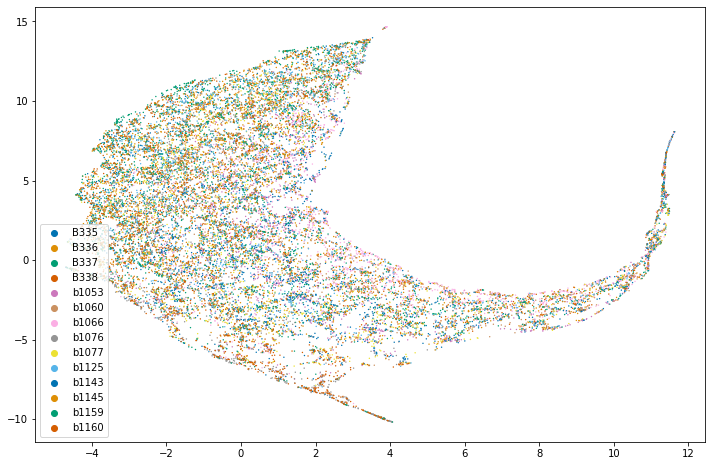

In [39]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x = embeddings_reduced[:,0], y = embeddings_reduced[:,1], 
                    hue = subj_list, s = 2, linewidth = 0, palette = 'colorblind')

### long specs

In [22]:
long_list = []
for spec in spec_list:
    long_list.append(np.stack([spec, spec, spec], axis = 2))

In [23]:
long_list = np.array(long_list)

In [26]:
clear_session()

In [27]:
model=self_VGG()

In [28]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
model_inputs = Input(shape=(spec_h, spec_w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
classifier = Model(model_inputs, model(resized))

In [30]:
weights_file = os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_07_14_21_46_52/weights-improvement.h5')

In [31]:
classifier.load_weights(weights_file, by_name=True)

In [32]:
embeddings = classifier.predict(long_list)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [38]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
subj_list_num = le.fit_transform(subj_list)

In [40]:
import umap

UMAP = umap.UMAP(n_neighbors=10, random_state=20)
embeddings_reduced = UMAP.fit_transform(embeddings, y=subj_list_num)

<AxesSubplot:>

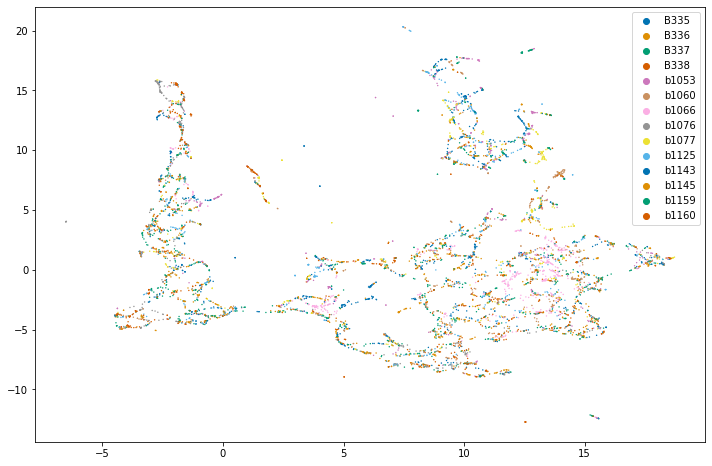

In [41]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x = embeddings_reduced[:,0], y = embeddings_reduced[:,1], 
                    hue = subj_list, s = 2, linewidth = 0, palette = 'colorblind')

# fine-tuned features

## long ones

In [15]:
long_list = []
for spec in spec_list:
    long_list.append(np.stack([spec, spec, spec], axis = 2))

In [16]:
long_list = np.array(long_list)

In [17]:
model=self_VGG()

In [18]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
model_inputs = Input(shape=(spec_h, spec_w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
classifier = Model(model_inputs, model(resized))

In [20]:
weights_file = os.path.join('/mnt/cube/kai/results/perceptual_loss/2021_07_14_21_46_52/subj_classification/unsegmented_trainable/weights-improvement.h5')
classifier.load_weights(weights_file, by_name=True)

In [21]:
embeddings = classifier.predict(long_list)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


In [22]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
subj_list_num = le.fit_transform(subj_list)

In [23]:
import umap

UMAP = umap.UMAP(n_neighbors=10, random_state=20)
embeddings_reduced = UMAP.fit_transform(embeddings, y=subj_list_num)

<AxesSubplot:>

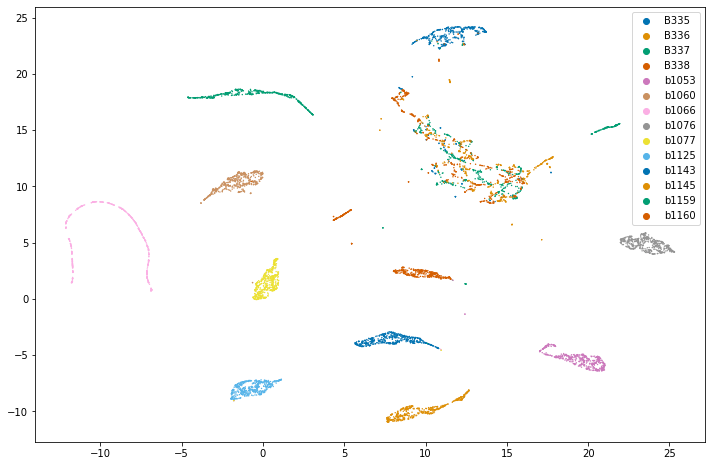

In [24]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x = embeddings_reduced[:,0], y = embeddings_reduced[:,1], 
                    hue = subj_list, s = 2, linewidth = 0, palette = 'colorblind')

## short ones

In [25]:
divided_w = spec_w//3
short_list = []

for spec in spec_list:
    for i in range(3):
        s = spec[:, divided_w*i:divided_w*(i+1)]
        short_list.append(np.stack([s, s, s], axis = 2))
short_list = np.array(short_list)

In [26]:
clear_session()

In [27]:
model=self_VGG()

In [28]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [29]:
model_inputs = Input(shape=(spec_h, divided_w, 3))
resized = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear")(model_inputs)
classifier = Model(model_inputs, model(resized))

In [30]:
classifier.load_weights(weights_file, by_name=True)

In [31]:
embeddings = classifier.predict(short_list)

In [32]:
import umap

UMAP = umap.UMAP(n_neighbors=10, random_state=20)
embeddings_reduced = UMAP.fit_transform(embeddings)

subj_list = list(itertools.chain.from_iterable(itertools.repeat(x, 3) for x in subj_list))

<AxesSubplot:>

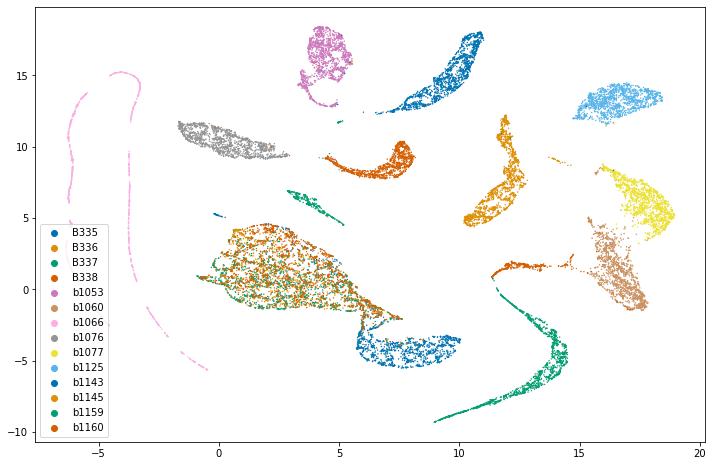

In [33]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x = embeddings_reduced[:,0], y = embeddings_reduced[:,1], 
                    hue = subj_list, s = 2, linewidth = 0, palette = 'colorblind')